# Use SurvivalEVAL for lifelines Model

In this notebook we introduce the use of `LifelinesEvaluator` in the package to evaluate the performance for a lifelines' CoxPH model.


The dataset we use in this example is the German Breast Cancer Study Group 2 dataset (GBSG2). The dataset contains 686 samples and 8 features. It has a censoring rate of 43.6\% with the target event of recurrence-free survival. 

We first perform a preprocessing on the GBSG2 dataset and split the training and testing datasets.

In [1]:
from lifelines.datasets import load_gbsg2
# Load the data and split train/test set
gbsg2 = load_gbsg2()
gbsg2 = gbsg2.replace({"horTh": {"no": 0, "yes": 1}, "menostat": {"Pre": 0, "Post": 1}, "tgrade": {"I": 1, "II": 2, "III": 3}})
train, test = gbsg2.iloc[:400, :], gbsg2.iloc[400:, :]

We then show the example of the first 5 rows of the training dataset: 

In [2]:
train.head()

,horTh,age,menostat,tsize,tgrade,pnodes,progrec,estrec,time,cens
0,0,70,1,21,2,3,48,66,1814,1
1,1,56,1,12,2,7,61,77,2018,1
2,1,58,1,35,2,9,52,271,712,1
3,1,59,1,17,2,4,60,29,1807,1
4,0,73,1,35,2,1,26,65,772,1


We can see that the dataset contains 8 features and 2 target columns: time and cens. The time column is the time to the event or censoring, and the cens column is the censoring indicator.

We then fit the ISD model on the training dataset and predict the survival curves on the testing dataset.

To be specific, we choose the most popular Cox proportional hazard (CoxPH) model to check and test the provided functionalities.

In [3]:
from lifelines import CoxPHFitter
isd_curves = CoxPHFitter().fit(train, duration_col="time", event_col="cens").predict_survival_function(test)

We can see that the ISD model returns a pandas dataframe with the survival curves of all the samples in the testing dataset. The index of the dataframe is the time points, and the columns are the sample IDs. 

Show the first 5 rows of the dataframe:

In [4]:
isd_curves.head()

,400,401,402,403,404,405,406,407,408,409,...,676,677,678,679,680,681,682,683,684,685
8.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
72.0,0.996027,0.997582,0.997735,0.997859,0.999507,0.997970,0.997636,0.999192,0.997294,0.998272,...,0.998179,0.998243,0.998402,0.998139,0.997620,0.997030,0.995452,0.997326,0.997280,0.997334
113.0,0.992061,0.995164,0.995470,0.995717,0.999014,0.995938,0.995271,0.998383,0.994589,0.996543,...,0.996356,0.996485,0.996803,0.996277,0.995239,0.994061,0.990913,0.994653,0.994561,0.994669
148.0,0.992061,0.995164,0.995470,0.995717,0.999014,0.995938,0.995271,0.998383,0.994589,0.996543,...,0.996356,0.996485,0.996803,0.996277,0.995239,0.994061,0.990913,0.994653,0.994561,0.994669
160.0,0.988080,0.992733,0.993192,0.993563,0.998517,0.993895,0.992894,0.997569,0.991870,0.994804,...,0.994523,0.994716,0.995194,0.994405,0.992846,0.991078,0.986360,0.991966,0.991828,0.991990


Once we get the predicted ISD curves for the test data from the model, we can then use the APIs in `SurvivalEVAL` to seamlessly plug in these ISD outputs. 

We first import the `LifelinesEvaluator` class from the package. The `LifelinesEvaluator` class takes the ISD curves, the time and censoring status of the test data, and the time and censoring status of the training data as inputs.


In [5]:
from Evaluator import LifelinesEvaluator
evl = LifelinesEvaluator(isd_curves, test.time, test.cens, train.time, train.cens)

We can plot the survival curves of the first 5 samples after the initialization of the `LifelinesEvaluator` class.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Time', ylabel='Survival probability'>)

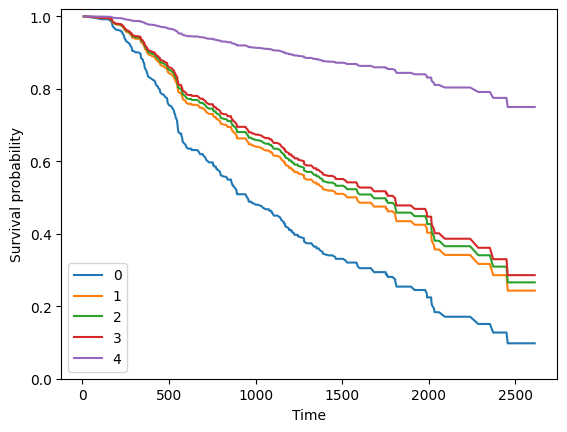

In [6]:
evl.plot_survival_curves(curve_indices=[0, 1, 2, 3, 4])

We can see that the five samples have the same shape of survival curves, but the survival probabilities are different. This is the nature of semi-parametric models.

Once the user gets everything ready, s/he can perform the evaluation, starting from the C-index.
The `concordance` method take two arguments: `ties` and `pair_method`, which specify the method to handle ties and the method to generate pairs, respectively. The default values are `None` and `Comparable`.

The method returns the C-index, the number of correctly ordered pairs, and the number of total comparable pairs.

In [7]:
cindex, correct_pairs, total_pairs = evl.concordance()
print("C-index: {:.4f}; \nNumber of correctly ordered pairs: {}; \nNumber of total comparable pairs: {}.".format(cindex, correct_pairs, total_pairs))

C-index: 0.6877; 
Number of correctly ordered pairs: 13630.0; 
Number of total comparable pairs: 19821.0.


To calculate MAE, one can use the `mae` method. The method takes three arguments: `method`, `weighted` and `log_scale`, which specify the method to calculate the pseudo observations,  whether to use the weighted MAE, and whether to use the logarithmic scale respectively. The default values are `Hinge`, `True`, and `False`.

In [8]:
mae = evl.mae(method="Pseudo_obs", weighted=True, log_scale=False)
print("MAE-PO: {:.4f}.".format(mae))

MAE-PO: 1770.7339.


One can also calculate the MSE using the `mse` method. The method takes the three arguments: `method`, `weighted` and `log_scale` as the `mae` method.

In [9]:
mse = evl.mse(method="Hinge", weighted=False, log_scale=True)
print("Mean Logarithmic Squared Error (MLSE) -Hinge: {:.4f}.".format(mse))

Mean Logarithmic Squared Error (MLSE) -Hinge: 0.4478.


To calculate the integrated Brier score, one can use the `integrated_brier_score` method. The method takes three argument: 
1. You can specify the number of points `num_points` to integral. If it is not specify, the default setting will use the censored time points obtained from testing set.
2. You can also set the `IPCW_weighted` as True or False to calculate the IPCW-weighted IBS or non-weighted IBS. The default setting is True.
3. `draw_figure` is a boolean value to decide whether to draw the IBS curve. The default setting is False.

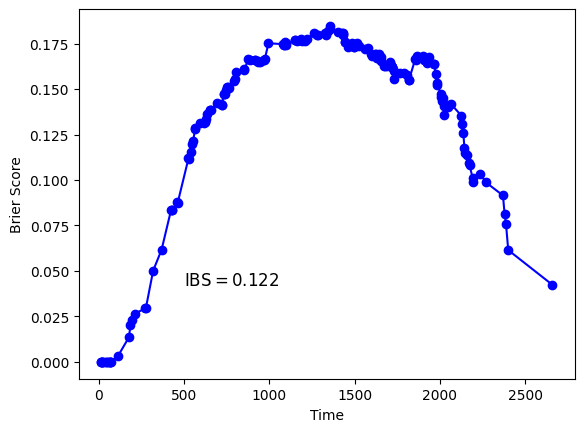

In [10]:
ibs = evl.integrated_brier_score(num_points=None, IPCW_weighted=True, draw_figure=True)

To calculate D-Cal, the user needs to decide how many bins they will use to split the quantile and performs the statistical test. A common choice could be 10 bins:

In [11]:
p_value, bin_hist = evl.d_calibration(num_bins=10)
if p_value >= 0.05:
    print("The model is d-calibrated!")
else:
    print("The model is not d-calibrated!")

The model is d-calibrated!


We can visualize the D-calibration results using the bin histogram to generate a quantile-quantile (q-q) plot.

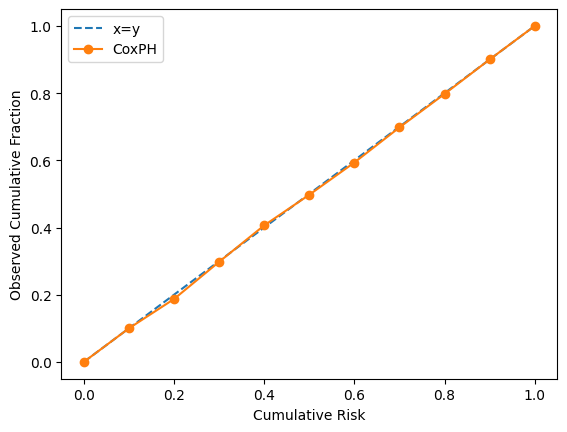

In [12]:
import numpy as np 
import matplotlib.pyplot as plt

bin_hist /= bin_hist.sum()

default = np.linspace(0, 1, 11)
plt.plot(default, default, linestyle='dashed', label="x=y")

fraction = np.concatenate((np.array([0]), bin_hist))
plt.plot(default, fraction.cumsum(), 'o-', label="CoxPH")

plt.xlabel("Cumulative Risk")
plt.ylabel("Observed Cumulative Fraction")
plt.legend()
plt.show()

If the user wants to evaluate the model's performance at a single time point, s/he can calculate the AUC, BS, and 1-Cal with a predefined target time (for example, 10 years).

In [13]:
target_t = 1000
auc = evl.auc(target_t)
bs = evl.brier_score(target_t)
p, ob, exp = evl.one_calibration(target_t)

print("AUC: {:.4f}; \nBS: {:.4f}.".format(auc, bs))
if p >= 0.05:
    print("The model is 1-calibrated!")
else:
    print("The model is not 1-calibrated!")

AUC: 0.7200; 
BS: 0.1751.
The model is 1-calibrated!


We can also visualize the 1-calibration results using the observed and expected probabilities to generate a reliability diagram.

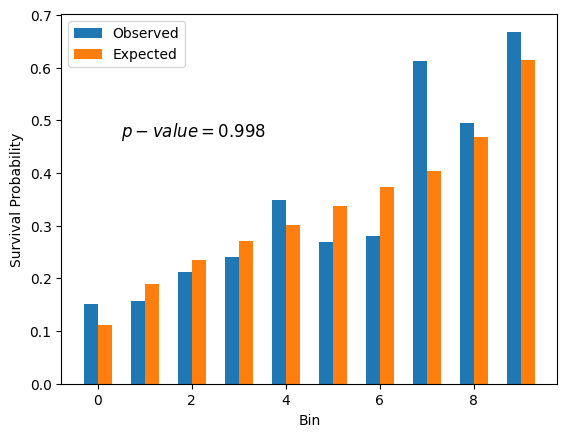

In [14]:
ob.reverse()
exp.reverse()

bins = np.arange(10)
plt.bar(bins - 0.15, ob, width=0.3, label="Observed")
plt.bar(bins + 0.15, exp, width=0.3, label="Expected")

plt.xlabel('Bin')
plt.ylabel('Survival Probability')
plt.text(0.5, 0.5, r'$p-value = {:.3f}$'.format(p_value), verticalalignment='top', horizontalalignment='left',
         fontsize=12, color='Black')
plt.legend()
plt.show()
## Calculate the distribution calibration (D-Calibration)